In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import ml4gw.waveforms as waveforms
from ml4gw.waveforms.conversion import (
    bilby_spins_to_lalsim,
    chirp_mass_and_mass_ratio_to_components,
)

In [3]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction
from torch.distributions import Uniform
num_waveforms = 10

In [4]:
from tests.waveforms.cbc.test_cbc_waveforms import test_phenom_d,test_phenom_deco

/Users/shrobana/Documents/Projects/ml4gw/tests/waveforms/cbc/test_cbc_waveforms.py:1: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
import random

In [7]:
torch.manual_seed(101589)
np.random.seed(101589)
random.seed(101589)

In [8]:
waveform_duration = 8
# Sample rate of all the data we'll be using today
sample_rate = 2048

# Define minimum, maximum, and reference frequencies
f_min = 20
f_max = 1024
f_ref = 20

nyquist = sample_rate / 2
num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1

# Create an array of frequency values at which to generate our waveform
# At the moment, only frequency-domain approximants have been implemented
frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
freq_mask = (frequencies >= f_min) * (frequencies < f_max).to(device)

In [9]:
from ml4gw.waveforms import IMRPhenomDECO, IMRPhenomD

approximant1 = IMRPhenomDECO().to(device)
approximant2 = IMRPhenomD().to(device)

In [10]:
param_dict = {
    "chirp_mass": PowerLaw(15, 20, -2.35),
    "mass_ratio": Uniform(0.9, 0.99),
    "chi1": Uniform(-0.9, 0.9),
    "chi2": Uniform(-0.9, 0.9),
    "distance": PowerLaw(1, 1.1, 2),
    "phic": DeltaFunction(0),
    "inclination": Sine(),
}

# And then sample from each of those distributions
params = {
    k: v.sample((num_waveforms,)).to(device) for k, v in param_dict.items()
}

In [11]:
test_phenom_d(params['chirp_mass'],params['mass_ratio'],params['chi1'],params['chi2'], \
                 params['distance'],0*torch.ones_like(params['chirp_mass']),0*torch.ones_like(params['chirp_mass']),4096.,10.0)

AssertionError: 

In [10]:
h_dict={}
compactness_parameter=[0.1,0.25,0.33,0.45,0.5] #  values between 0.05 to 0.5
for i,cc in enumerate(compactness_parameter):
    params_deco =params.copy()
    #add compactness to params for phenomDECO
    params_deco["compactness"]=torch.tensor([cc]) 
    hc1_f, hp1_f = approximant1(f=frequencies[freq_mask], f_ref=f_ref, **params_deco) 
    h_dict[cc] = [hc1_f, hp1_f]

In [16]:
params_deco =params.copy()

In [17]:
params_deco["compactness"] = 0.5*torch.ones_like(params["chirp_mass"])

#### 1. atol 1e-3
#### 2. sporadic behavior of assert not torch.any(torch.isnan(hc_ml4gw))

In [20]:
test_phenom_deco(params_deco['chirp_mass'],params_deco['mass_ratio'],params_deco['chi1'],params_deco['chi2'],params_deco["compactness"], \
                 params_deco['distance'],0*torch.ones_like(params_deco['chirp_mass']),0*torch.ones_like(params_deco['chirp_mass']), \
                 4096.,20.)

In [11]:
#Calculate total mass from chirp mass and mass ratio
print("total mass =",params['chirp_mass']/((params['mass_ratio']/(1+params['mass_ratio'])**2)**(3/5)))

total mass = tensor([37.7870])


In [12]:
#generate PhenomD for same parameters
hc2_f, hp2_f = approximant2(f=frequencies[freq_mask], f_ref=f_ref, **params)

/var/folders/_m/p0l5tvpx1td99rt__sftt7500000gn/T/ipykernel_15562/1095215476.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.1][1].T),label="C=0.1")
/var/folders/_m/p0l5tvpx1td99rt__sftt7500000gn/T/ipykernel_15562/1095215476.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.25][1].T),label="C=0.25")
/var/folders/_m/p0l5tvpx1td99rt__sftt7500000gn/T/ipykernel_15562/1095215476.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.33][1].T),label="C=0.33")
/var/folders/_m/p0l5tvpx1td99rt__sftt7500000gn/T/ipykernel_15562/1095215476.py:5: DeprecationWarning: __array_wrap

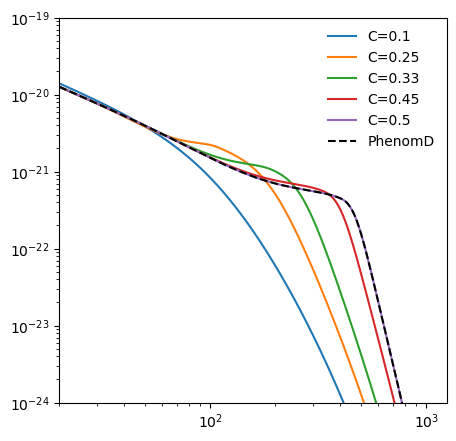

In [13]:
plt.figure(figsize=(5,5))
plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.1][1].T),label="C=0.1")
plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.25][1].T),label="C=0.25")
plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.33][1].T),label="C=0.33")
plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.45][1].T),label="C=0.45")
plt.loglog(frequencies[freq_mask],np.abs(h_dict[0.5][1].T),label="C=0.5")
# # plt.loglog(Mf.T,np.abs(hc_f.T),'^')
plt.loglog(frequencies[freq_mask],np.abs(hp2_f.T),'k--',label="PhenomD")
plt.ylim(1e-24,1e-19)
plt.xlim(20,)
plt.legend(frameon=False)